In [5]:
# Create candidates.tsv files for different number of neighbours
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER")
os.environ['LASER'] = "${HOME}/LASER"
powers_of_two = [2**p for p in range(6,8)]
for neigh in powers_of_two:
    command = ['python', 'source/mine_bitexts.py','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.de','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.en','--src-lang','de','--trg-lang','en','--src-embeddings','/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de', '--trg-embeddings','/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en','--mode','mine','--retrieval','max','--margin','ratio','-k',str(neigh),'--output', '/checkpoint/marialomeli/bucc_evaluation','--code_size', '8', '--verbose', '--fp16', '--unify']
    output = subprocess.check_output(command, universal_newlines=True)
    print(output)

2023-06-27 12:19:33,648 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
LASER: tool to search, score or mine bitexts
 - knn will run on CPU (slow)
 - loading texts /checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.de: 413869 lines, 412909 unique
 - loading texts /checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt.en: 399337 lines, 397151 unique
 - Embeddings: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de, 413869x1024
 - unify embeddings: 413869 -> 412909
 - Embeddings: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en, 399337x1024
 - unify embeddings: 399337 -> 397151
loading bigger file and adjusting size to 64:
 - mining for parallel data
 - scoring 412909 candidates
 - scoring 397151 candidates
 - writing alignments to /checkpoint/marialomeli/bucc_evaluation/sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k64.candid

In [11]:

# load candidate.tsv files and compute precision and recall
# can run bucc.py with the given file name and collect the output
# we don't need to run for all values of k, we can reuse one of the files 
# with lots of neighbours and select a subset 
powers_of_two = [2**p for p in range(1,8)]+[200]
code_sizes = [16,32,64,128,256,512]
files = {}
flat =[f"sonar.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
flat_diff=[f"sonar_difference.k{neigh}.bucc2018.de-en.train.candidates.tsv" for neigh in powers_of_two]
sq8=[f"sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
files["flat"]=flat
files["sq8"]=sq8
for code_size in code_sizes:
    pq_helper = [f"sonar.margin_ratio.retrieval_max.bucc2018.de-en.PQ{code_size}.train.k{neigh}.candidates.tsv" for neigh in powers_of_two]
    files[f"pq{code_size}"]=pq_helper

print(files)

{'flat': ['sonar.k2.bucc2018.de-en.train.candidates.tsv', 'sonar.k4.bucc2018.de-en.train.candidates.tsv', 'sonar.k8.bucc2018.de-en.train.candidates.tsv', 'sonar.k16.bucc2018.de-en.train.candidates.tsv', 'sonar.k32.bucc2018.de-en.train.candidates.tsv', 'sonar.k64.bucc2018.de-en.train.candidates.tsv', 'sonar.k128.bucc2018.de-en.train.candidates.tsv', 'sonar.k200.bucc2018.de-en.train.candidates.tsv'], 'sq8': ['sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k2.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k4.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k8.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k16.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k32.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k64.candidates.tsv', 'sonar.margin_ratio.retrieval_max.bucc2018.de-en.SQ8.train.k128.candidates.tsv', 'sonar.margin_ratio.retrieval_ma

In [12]:
import subprocess
import itertools
import os
os.chdir("/private/home/marialomeli/LASER/tasks/bucc")
thresholds = {}
precisions= {}
recalls = {}
F1 =  {}
results_directory="/private/home/marialomeli/LASER/tasks/bucc/embed/"
for index_string in files.keys():
    thresholds[index_string]=[]
    precisions[index_string]=[]
    recalls[index_string]=[]
    F1[index_string]=[]
    for filename in files[index_string]:
        assert os.path.exists(results_directory+filename), f"file does not exist {results_directory+filename}"
        command = ['python', 'bucc.py','--src-lang','de','--trg-lang','en','--bucc-texts','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.txt','--bucc-ids','/checkpoint/marialomeli/bucc_evaluation/bucc2018.de-en.train.id','--candidates','./embed/'+filename,'--gold','./bucc2018/de-en/de-en.training.gold','--verbose']
        output = subprocess.check_output(command, universal_newlines=True)
        print(filename)
        print(output)
        allbits=output.split('\n')
        helper = [bit.split(',') for bit in allbits[4].split('=')]
        all_metrics = list(itertools.chain.from_iterable(helper))
        thresholds[index_string].append(float(all_metrics[1]))
        precisions[index_string].append(float(all_metrics[3]))
        recalls[index_string].append(float(all_metrics[5]))
        F1[index_string].append(float(all_metrics[7]))

print(thresholds,recalls,precisions,F1)

sonar.k2.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k2.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.183773, precision=93.21, recall=90.73, F1=91.95

sonar.k4.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k4.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.352864, precision=93.27, recall=91.12, F1=92.18

sonar.k8.bucc2018.de-en.train.candidates.tsv
LASER: tools for BUCC bitext mining
 - reading sentences and IDs
 - reading candidates ./embed/sonar.k8.bucc2018.de-en.train.candidates.tsv
 - optimizing threshold on gold alignments ./bucc2018/de-en/de-en.training.gold
 - best threshold=1.493512, precision=92.50, recall=91.27, F1=91.88

flat
sq8
pq16
pq32
pq64
pq128
pq256
pq512


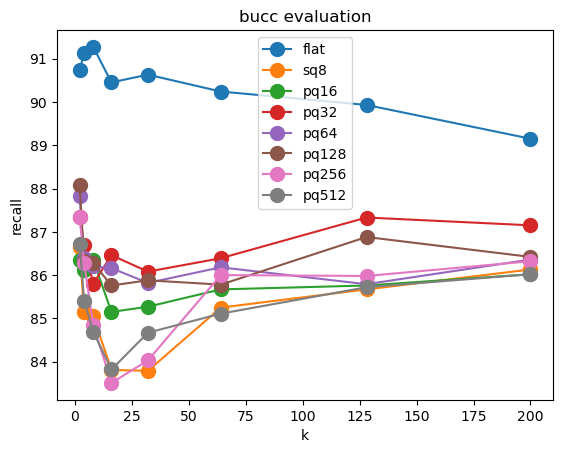

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ["g", "b", "r", "m", "y", "c",'k'] 
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, recalls[file], "o-", markersize=10, color=colors[i], label=file)

    #plt.plot(powers_of_two,recalls["ratio"], "o-", markersize=10, color=colors[2],label=index_strings[0])
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("recall")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
sq8
pq16
pq32
pq64
pq128
pq256
pq512


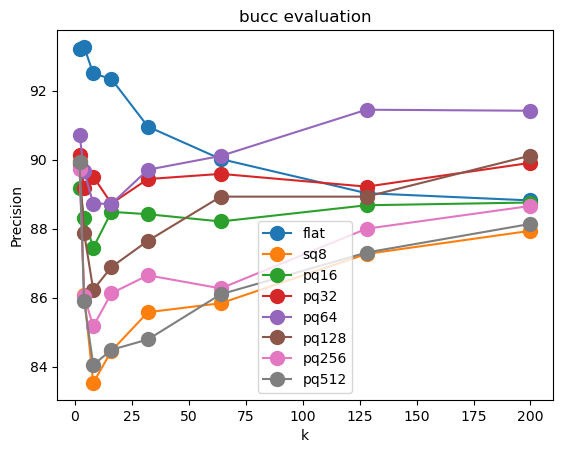

In [15]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,precisions[file], "o-", markersize=10, color=colors[i],label=file)
#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("Precision")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
sq8
pq16
pq32
pq64
pq128
pq256
pq512


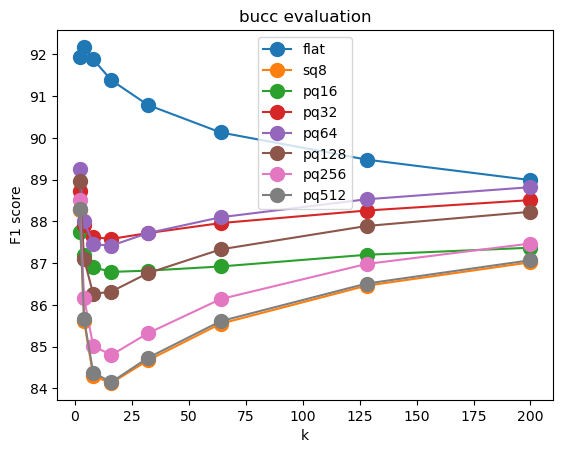

In [16]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two,F1[file], "o-", markersize=10, color=colors[i],label=file)

#plt.xscale("log")

plt.xlabel("k")
plt.ylabel("F1 score")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

flat
sq8
pq16
pq32
pq64
pq128
pq256
pq512


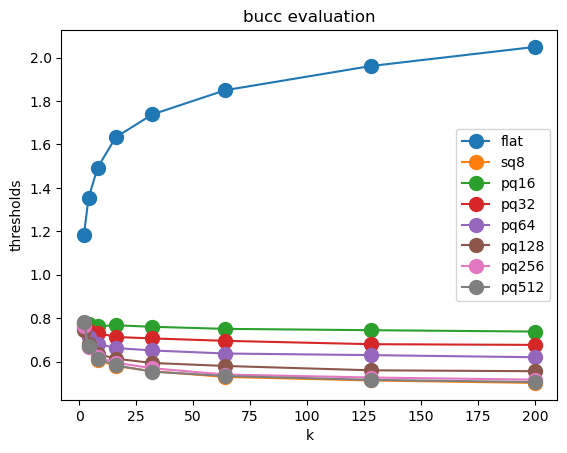

In [17]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
powers_of_two = [2**p for p in range(1,8)]+[200]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


for i,file in enumerate(files.keys()):
    print(file)
    plt.plot(powers_of_two, thresholds[file], "o-", markersize=10, color=colors[i], label=file)
#plt.xscale("log")
plt.xlabel("k")
plt.ylabel("thresholds")
#plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("bucc evaluation")
plt.legend()
plt.show()

In [19]:
import numpy as np
def EmbedLoad(fname, dim=1024, verbose=False, fp16=False):
    x = np.fromfile(fname, dtype=(np.float16 if fp16 else np.float32), count=-1)
    x.resize(x.shape[0] // dim, dim)
    if verbose:
        print(" - Embeddings: {:s}, {:d}x{:d}".format(fname, x.shape[0], dim))
    return x


In [34]:
import faiss
import glob
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/*de-en.train.*"
for file in  glob.iglob(common_dir):
    print("Matrix stats for:",
          file)
    x = EmbedLoad(file,fp16=True)
    print(faiss.MatrixStats(x).comments)

Matrix stats for: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.de
analyzing 413869 vectors of size 1024
no NaN or Infs in data
412932 vectors are distinct (99.77%)
vector 1178 has 37 copies
range of L2 norms=[0.129181, 0.389608] (0 null vectors)
matrix contains 0.00 % 0 entries
no constant dimensions
no dimension has a too large mean
stddevs per dimension are in [6.1706e-05 0.014338]

Matrix stats for: /private/home/marialomeli/LASER/tasks/bucc/embed/sonar_embeds/encf.bucc2018.de-en.train.en
analyzing 399337 vectors of size 1024
no NaN or Infs in data
397246 vectors are distinct (99.48%)
vector 356131 has 8 copies
range of L2 norms=[0.125195, 0.381765] (0 null vectors)
matrix contains 0.00 % 0 entries
no constant dimensions
no dimension has a too large mean
stddevs per dimension are in [4.98589e-05 0.0141463]



In [5]:
import numpy as np
from faiss.contrib.evaluation import knn_intersection_measure
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sim_and_ind/"
x2y_flat = np.load(common_dir+"de-en.x2y_ind.npy") 

powers_of_two = [2**p for p in range(1,8)]+[200]
knn_im={}
knn_im["SQ_8"]=[]
x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 
for k in powers_of_two:
        knn_im["SQ_8"].append(knn_intersection_measure(x2y_flat[:,:k], x2y_sq[:,:k]))
code_sizes = [16,32,64,128,256,512]
for code_size in code_sizes:
    knn_im["PQ_"+str(code_size)]=[]
    x2y_pq = np.load(common_dir+f"de-en.PQ{code_size}.x2y_ind.npy") 
    for k in powers_of_two:
        knn_im["PQ_"+str(code_size)].append(knn_intersection_measure(x2y_flat[:,:k], x2y_pq[:,:k]))

x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 

knn_im


{'SQ_8': [0.9898476419743818,
  0.9896744803334391,
  0.9898458255935327,
  0.9901437120527767,
  0.9904445501309005,
  0.9910312411451434,
  0.9916162482229741,
  0.9919224453814278,
  0.9898476419743818,
  0.9896744803334391,
  0.9898458255935327,
  0.9901437120527767,
  0.9904445501309005,
  0.9910312411451434,
  0.9916162482229741,
  0.9919224453814278],
 'PQ_16': [0.08302434676890065,
  0.09039824755575684,
  0.10110611539104258,
  0.11428971032358219,
  0.1304316598814751,
  0.14953737536600073,
  0.1716532312507114,
  0.18744463065711817],
 'PQ_32': [0.19974255828766144,
  0.21232160112760923,
  0.2233639857692615,
  0.2349051183190485,
  0.24662932692191258,
  0.2600897307275937,
  0.2756215276852769,
  0.2866378548299989],
 'PQ_64': [0.37125129265770423,
  0.38708165721744986,
  0.3975533955423592,
  0.4049368323286729,
  0.41087836545098316,
  0.41702382516486686,
  0.4240487727017333,
  0.4293699095926705],
 'PQ_128': [0.55005097975583,
  0.5672363644289662,
  0.578467955409

ValueError: x and y must have same first dimension, but have shapes (8,) and (16,)

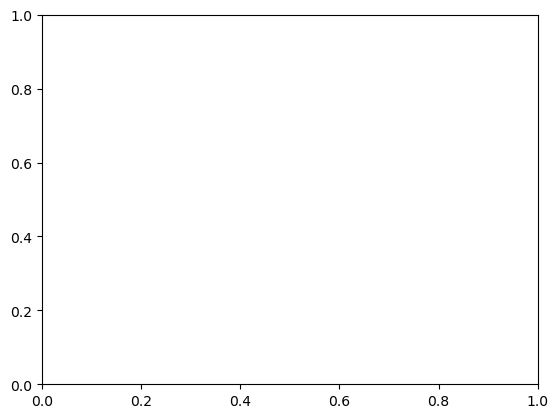

In [6]:
import numpy as np
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
powers_of_two = [2**p for p in range(1,8)]+[200]
ell=0
for i, knn in knn_im.items():
    plt.plot(powers_of_two, knn, "o-", markersize=10, color=colors[ell], label=i)
    ell+=1
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("knn_intersection_measure")
plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("knn intersection measure x2y")
plt.legend()
plt.show()

In [7]:
import numpy as np
from faiss.contrib.evaluation import knn_intersection_measure
common_dir = "/private/home/marialomeli/LASER/tasks/bucc/embed/sim_and_ind/"
y2x_flat = np.load(common_dir+"de-en.y2x_ind.npy") 

powers_of_two = [2**p for p in range(1,8)]+[200]
knn_im={}
knn_im["SQ_8"]=[]
x2y_sq = np.load(common_dir+"de-en.SQ8.x2y_ind.npy") 
for k in powers_of_two:
        knn_im["SQ_8"].append(knn_intersection_measure(x2y_flat[:,:k], x2y_sq[:,:k]))
code_sizes = [16,32,64,128,256,512]
for code_size in code_sizes:
    knn_im["PQ_"+str(code_size)]=[]
    y2x_pq = np.load(common_dir+f"de-en.PQ{code_size}.y2x_ind.npy") 
    for k in powers_of_two:
        knn_im["PQ_"+str(code_size)].append(knn_intersection_measure(y2x_flat[:,:k], y2x_pq[:,:k]))
knn_im["SQ_8"]=[]
x2y_sq = np.load(common_dir+f"de-en.SQ8.x2y_ind.npy") 
for k in powers_of_two:
        knn_im["SQ_8"].append(knn_intersection_measure(x2y_flat[:,:k], x2y_sq[:,:k]))

knn_im

{'PQ_16': [0.08379558404737744,
  0.0897517568884379,
  0.0988056180143069,
  0.11027370571898346,
  0.12425516365311934,
  0.14140858892461558,
  0.16141833490284552,
  0.17580857155087107],
 'PQ_32': [0.2003230509302507,
  0.21042626104428794,
  0.21978258899008185,
  0.22899869948709684,
  0.2391884635818618,
  0.2506925105312589,
  0.2640392917303494,
  0.2738544533439422],
 'PQ_64': [0.36930663651860374,
  0.38384581683037433,
  0.39235108308930355,
  0.39715467164881874,
  0.4008813713172068,
  0.40476083876157937,
  0.4097936970132267,
  0.4139087148213148],
 'PQ_128': [0.5455305412802687,
  0.5614986491284172,
  0.5709320888024958,
  0.5743926743228646,
  0.5754875821790705,
  0.5755209054616506,
  0.5756674570881101,
  0.576399077428988],
 'PQ_256': [0.7331858663329565,
  0.745215925428867,
  0.7549272820665188,
  0.7603397385377351,
  0.7624283647781323,
  0.763084483294767,
  0.7632015868964197,
  0.7635227659001236],
 'PQ_512': [0.9014228844948143,
  0.904402229882337,
  0.

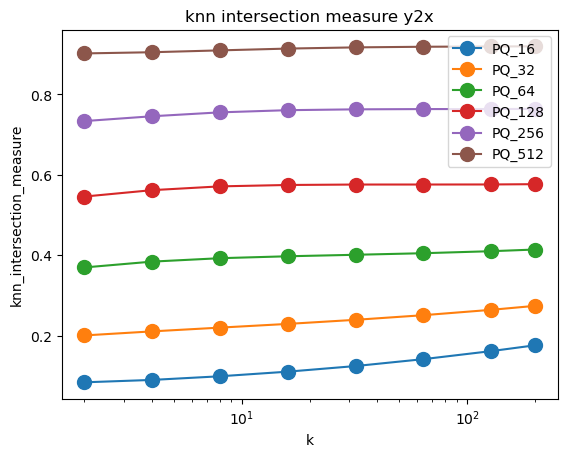

In [8]:
import numpy as np
import matplotlib.pyplot as plt
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
powers_of_two = [2**p for p in range(1,8)]+[200]
ell=0
for i, knn in knn_im.items():
    plt.plot(powers_of_two, knn, "o-", markersize=10, color=colors[ell], label=i)
    ell+=1
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("knn_intersection_measure")
plt.savefig("logscale_knn_intesection_metric.pdf")
plt.title("knn intersection measure y2x")
plt.legend()
plt.show()